In [1]:
import os
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import chi2_contingency

# ---- SETTINGS ---- #
BASE_DIR = "/mnt/jwh83-data/Confetti/output/Redsea/MicroSAM"  
MARKERS = ["CD4", "CD8"]  
THRESHOLDS = {m: 0.0 for m in MARKERS}  # example threshold; customize

# define mutually exclusive markers (pairs)
MUTUALLY_EXCLUSIVE = [
    ("CD4", "CD8"),  # example  # modify as needed
]

In [2]:
def load_slide(slide_path):
    """Load before/after CSV inside a slide folder."""
    before = pd.read_csv(os.path.join(slide_path, "single_cell_before_redsea.csv"))
    after  = pd.read_csv(os.path.join(slide_path, "single_cell_after_redsea.csv"))
    return before, after

def binarize(df):
    """Convert marker intensities to positive/negative."""
    out = df.copy()
    for m in MARKERS:
        out[m + "_bin"] = (out[m] > THRESHOLDS[m]).astype(int)
    return out

def mcnemar_for_marker(before_bin, after_bin, marker):
    """
    Returns McNemar test result for marker positivity change.
    """
    b = before_bin[marker + "_bin"]
    a = after_bin[marker + "_bin"]
    
    # contingency table
    #        After
    #       0    1
    # B 0 [n00, n01]
    # e 1 [n10, n11]
    n00 = ((b == 0) & (a == 0)).sum()
    n01 = ((b == 0) & (a == 1)).sum()
    n10 = ((b == 1) & (a == 0)).sum()
    n11 = ((b == 1) & (a == 1)).sum()

    table = [[n00, n01],
             [n10, n11]]
    
    result = mcnemar(table, exact=False)
    return table, result

def analyze_mutual_exclusivity(df, markerA, markerB):
    """
    Count double-positive cells that violate mutual exclusivity.
    """
    return ((df[markerA + "_bin"] == 1) & (df[markerB + "_bin"] == 1)).sum()


In [3]:
slide_results = []

for slide in os.listdir(BASE_DIR):
    slide_path = os.path.join(BASE_DIR, slide)
    if not os.path.isdir(slide_path):
        continue
    
    before, after = load_slide(slide_path)
    before_bin = binarize(before)
    after_bin  = binarize(after)

    slide_data = {"slide": slide}

    # McNemar for each marker
    for m in MARKERS:
        table, result = mcnemar_for_marker(before_bin, after_bin, m)
        slide_data[f"{m}_table"] = table
        slide_data[f"{m}_mcnemar_p"] = result.pvalue

    # Mutual exclusivity violations
    for A, B in MUTUALLY_EXCLUSIVE:
        before_viol = analyze_mutual_exclusivity(before_bin, A, B)
        after_viol  = analyze_mutual_exclusivity(after_bin, A, B)
        slide_data[f"{A}_{B}_viol_before"] = before_viol
        slide_data[f"{A}_{B}_viol_after"] = after_viol

    slide_results.append(slide_data)

results_df = pd.DataFrame(slide_results)
print(results_df)


        slide                      CD4_table  CD4_mcnemar_p  \
0  B004-A-008    [[318, 315], [2197, 24786]]  2.982541e-308   
1  B004-A-504      [[48, 38], [2387, 38621]]   0.000000e+00   
2  B004-A-404    [[187, 166], [2969, 27665]]   0.000000e+00   
3  B004-A-004     [[426, 413], [1101, 9995]]   9.140122e-70   
4  B004-A-104  [[1320, 1103], [2431, 26324]]  2.247752e-110   
5  B004-A-304    [[198, 214], [1248, 15341]]  9.498013e-161   
6  B004-A-408    [[137, 121], [1754, 22835]]  7.401556e-311   
7  B004-A-204     [[119, 91], [1720, 17111]]   0.000000e+00   

                     CD8_table  CD8_mcnemar_p  CD4_CD8_viol_before  \
0  [[112, 109], [4477, 22918]]   0.000000e+00                26915   
1    [[48, 36], [6868, 34142]]   0.000000e+00                40986   
2    [[33, 50], [5620, 25284]]   0.000000e+00                30593   
3  [[146, 167], [1208, 10414]]  4.380663e-173                11015   
4  [[783, 689], [3061, 26645]]   0.000000e+00                28459   
5    [[15, 1

In [4]:
MARKERS_FOR_TABLE = ["CD4", "CD8"]

def print_mcnemar_tables(results_df, markers=MARKERS_FOR_TABLE):
    """
    Pretty-print 2x2 McNemar tables + p-values for each slide and marker.
    Assumes columns like 'MUC2_table' and 'MUC2_mcnemar_p' exist.
    """
    for _, row in results_df.iterrows():
        print("=" * 80)
        print(f"Slide: {row['slide']}")
        print("-" * 80)
        
        for m in markers:
            table_col = f"{m}_table"
            p_col     = f"{m}_mcnemar_p"
            
            # skip markers that aren't in this DataFrame
            if table_col not in results_df.columns or p_col not in results_df.columns:
                continue
            
            t = row[table_col]
            p = row[p_col]
            
            # unpack the 2x2 table: [[n00, n01], [n10, n11]]
            n00, n01 = t[0]
            n10, n11 = t[1]
            
            print(f"\nMarker: {m}")
            print(f"McNemar p-value: {p:.3e}")
            print("Contingency table (Before vs After):")
            print()
            print("            After = 0    After = 1")
            print(f"Before = 0   {n00:8d}   {n01:8d}")
            print(f"Before = 1   {n10:8d}   {n11:8d}")
        
        print("\n")  # blank line between slides


# usage:
print_mcnemar_tables(results_df)


Slide: B004-A-008
--------------------------------------------------------------------------------

Marker: CD4
McNemar p-value: 2.983e-308
Contingency table (Before vs After):

            After = 0    After = 1
Before = 0        318        315
Before = 1       2197      24786

Marker: CD8
McNemar p-value: 0.000e+00
Contingency table (Before vs After):

            After = 0    After = 1
Before = 0        112        109
Before = 1       4477      22918


Slide: B004-A-504
--------------------------------------------------------------------------------

Marker: CD4
McNemar p-value: 0.000e+00
Contingency table (Before vs After):

            After = 0    After = 1
Before = 0         48         38
Before = 1       2387      38621

Marker: CD8
McNemar p-value: 0.000e+00
Contingency table (Before vs After):

            After = 0    After = 1
Before = 0         48         36
Before = 1       6868      34142


Slide: B004-A-404
---------------------------------------------------------------

In [5]:
import numpy as np

def print_violation_summary(results_df):
    """
    Pretty-print mutual-exclusivity violation counts for each slide and pair.
    Looks for columns like '<PAIR>_viol_before' / '<PAIR>_viol_after'.
    """
    # detect all pairs automatically
    pairs = sorted({
        c.replace("_viol_before", "")
        for c in results_df.columns
        if c.endswith("_viol_before")
    })

    for _, row in results_df.iterrows():
        print("=" * 80)
        print(f"Slide: {row['slide']}")
        print("-" * 80)

        for pair in pairs:
            before_col = f"{pair}_viol_before"
            after_col  = f"{pair}_viol_after"
            if before_col not in results_df.columns or after_col not in results_df.columns:
                continue

            before = row[before_col]
            after  = row[after_col]

            delta = after - before
            if before > 0:
                pct_change = 100 * (after - before) / before
            else:
                pct_change = np.nan

            print(f"\nPair: {pair}")
            print(f"  Violations before : {before:6d}")
            print(f"  Violations after  : {after:6d}")
            print(f"  Absolute change   : {delta:+6d}")
            if np.isnan(pct_change):
                print(f"  Percent change    :   n/a")
            else:
                print(f"  Percent change    : {pct_change:+7.2f}%")

        print("\n")  # blank line between slides


# run it:
print_violation_summary(results_df)


Slide: B004-A-008
--------------------------------------------------------------------------------

Pair: CD4_CD8
  Violations before :  26915
  Violations after  :  21471
  Absolute change   :  -5444
  Percent change    :  -20.23%


Slide: B004-A-504
--------------------------------------------------------------------------------

Pair: CD4_CD8
  Violations before :  40986
  Violations after  :  32934
  Absolute change   :  -8052
  Percent change    :  -19.65%


Slide: B004-A-404
--------------------------------------------------------------------------------

Pair: CD4_CD8
  Violations before :  30593
  Violations after  :  23550
  Absolute change   :  -7043
  Percent change    :  -23.02%


Slide: B004-A-004
--------------------------------------------------------------------------------

Pair: CD4_CD8
  Violations before :  11015
  Violations after  :   9547
  Absolute change   :  -1468
  Percent change    :  -13.33%


Slide: B004-A-104
----------------------------------------------

In [6]:
import matplotlib.pyplot as plt

def plot_before_after_scatter(base_dir=BASE_DIR, markers=MARKERS, results_df=results_df, max_points=100000):
    """
    For each slide, plot scatter of per-cell marker intensity:
    x = before Redsea, y = after Redsea.
    """
    for slide in results_df["slide"]:
        slide_path = os.path.join(base_dir, slide)
        if not os.path.isdir(slide_path):
            continue

        # Load data
        before, after = load_slide(slide_path)

        # Require CellID to align cells
        if "CellID" not in before.columns or "CellID" not in after.columns:
            print(f"Skipping {slide}: no 'CellID' column to align cells.")
            continue

        # Subset to CellID + markers and rename columns
        cols = ["CellID"] + [m for m in markers if m in before.columns and m in after.columns]
        if len(cols) <= 1:
            print(f"Skipping {slide}: none of {markers} present in both before/after.")
            continue

        before_sub = before[cols].rename(columns={m: f"{m}_before" for m in markers if m in before.columns})
        after_sub  = after[cols].rename(columns={m: f"{m}_after"  for m in markers if m in after.columns})

        # Inner join on CellID so we compare the same cells
        merged = pd.merge(before_sub, after_sub, on="CellID", how="inner")
        if merged.empty:
            print(f"Skipping {slide}: no overlapping CellID rows.")
            continue

        # Optional subsampling for readability
        if len(merged) > max_points:
            merged_plot = merged.sample(max_points, random_state=0)
        else:
            merged_plot = merged

        # One subplot per marker
        valid_markers = [m for m in markers if f"{m}_before" in merged_plot.columns and f"{m}_after" in merged_plot.columns]
        if not valid_markers:
            print(f"Skipping {slide}: no valid markers after merge.")
            continue

        n_markers = len(valid_markers)
        fig, axes = plt.subplots(1, n_markers, figsize=(5 * n_markers, 5))
        if n_markers == 1:
            axes = [axes]

        fig.suptitle(f"Before vs After Redsea Marker Intensities - {slide}")

        for ax, m in zip(axes, valid_markers):
            x = merged_plot[f"{m}_before"]
            y = merged_plot[f"{m}_after"]

            ax.scatter(x, y, alpha=0.3, s=5)

            # Identity line
            min_val = min(x.min(), y.min())
            max_val = max(x.max(), y.max())
            ax.plot([min_val, max_val], [min_val, max_val], linestyle="--")

            ax.set_xlabel(f"{m} before")
            ax.set_ylabel(f"{m} after")
            ax.set_title(m)

        plt.tight_layout()
        plt.show()



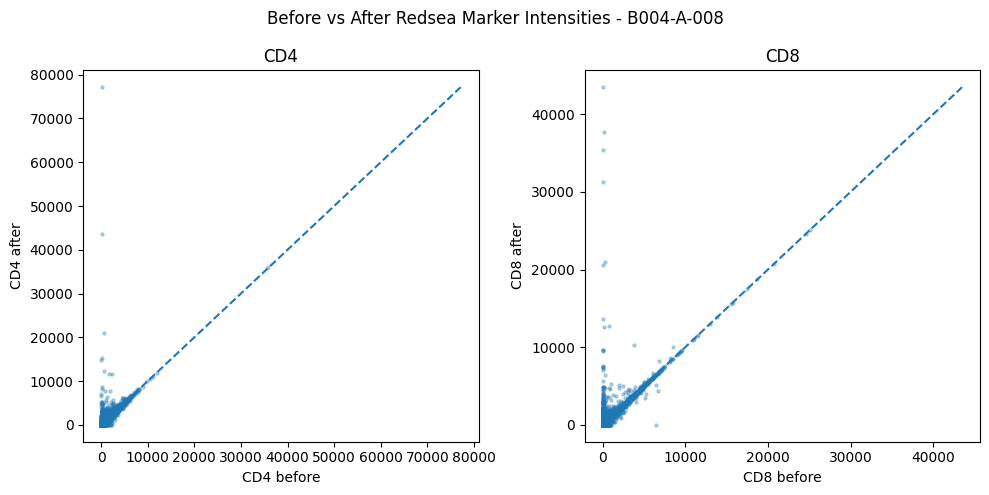

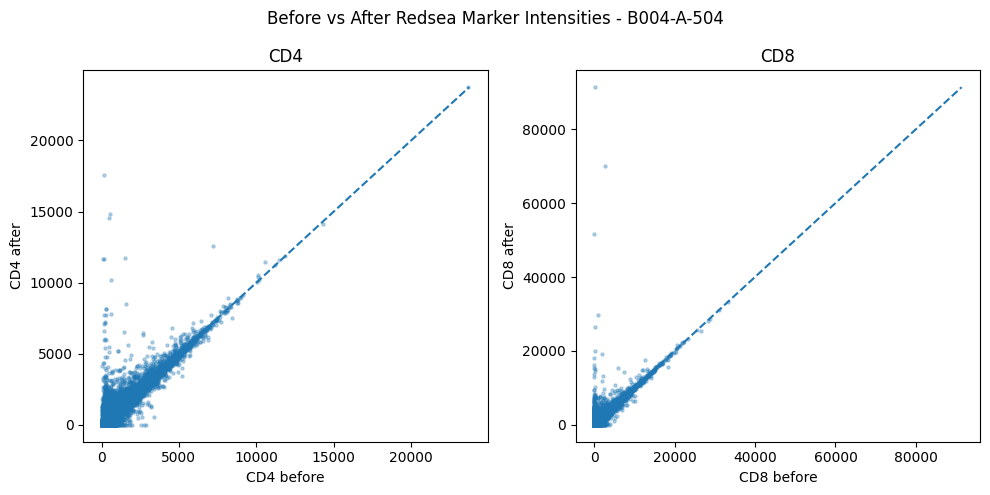

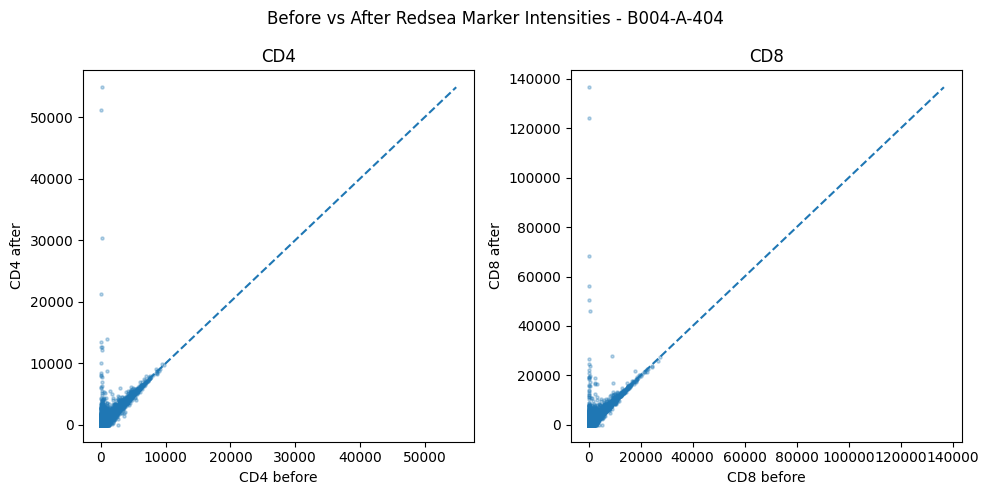

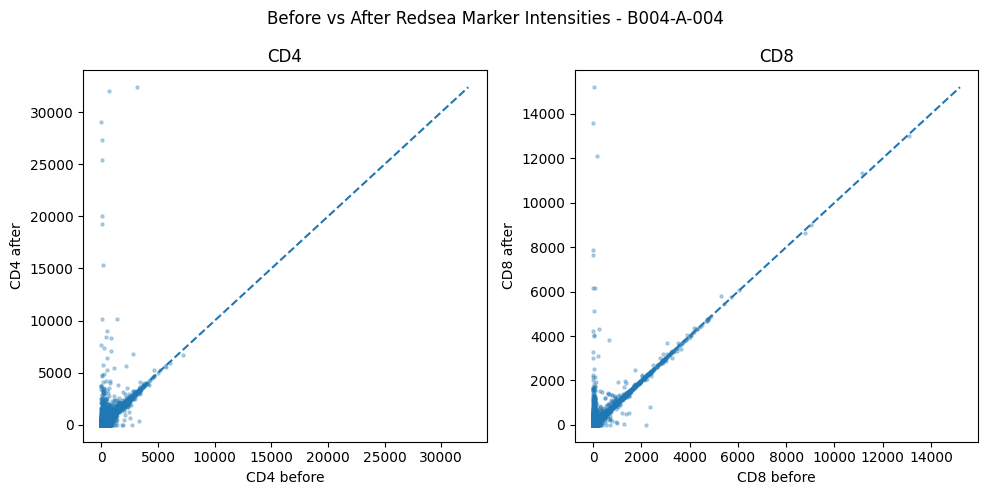

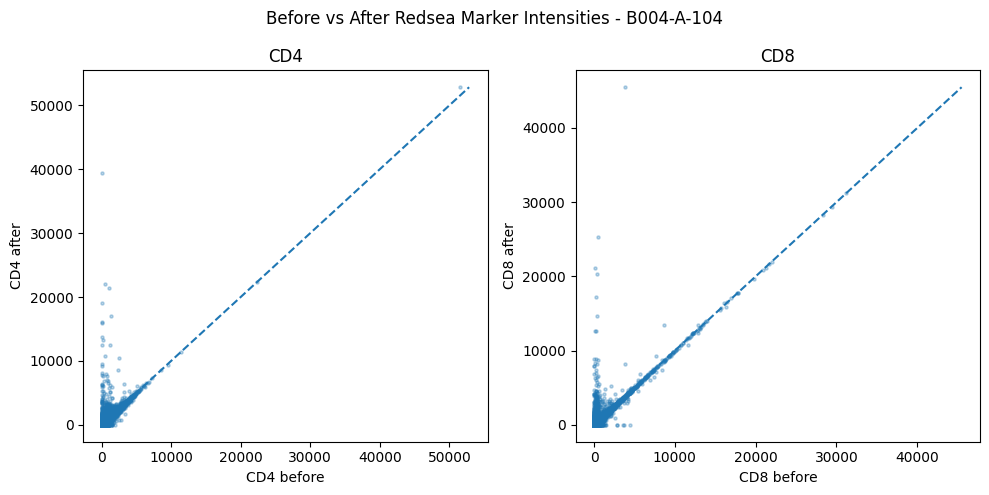

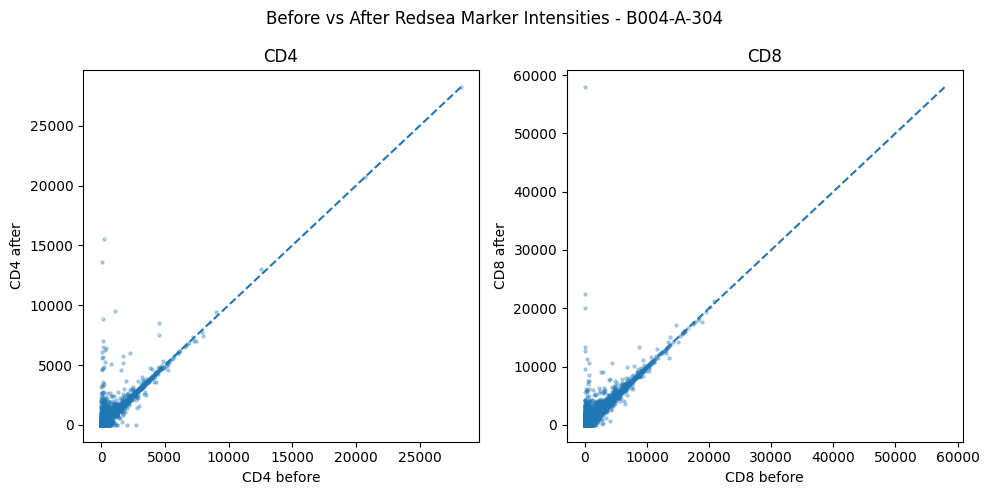

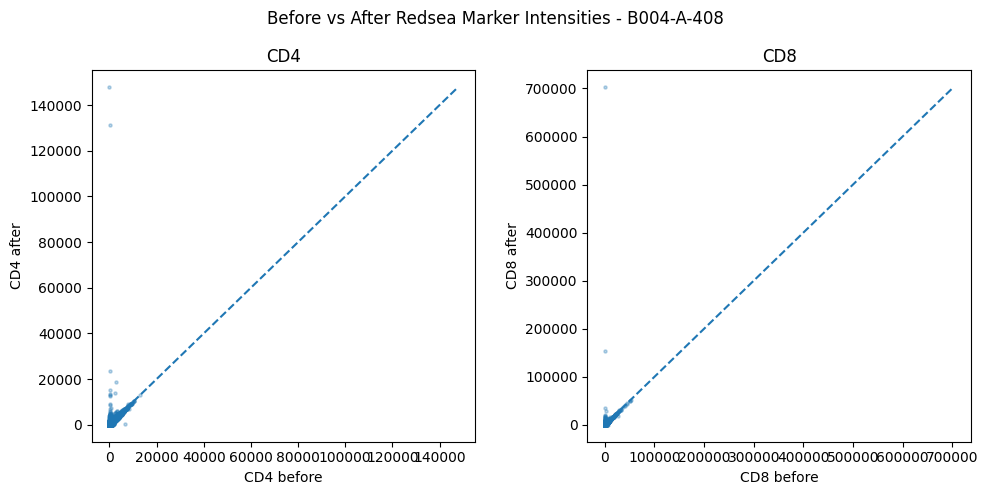

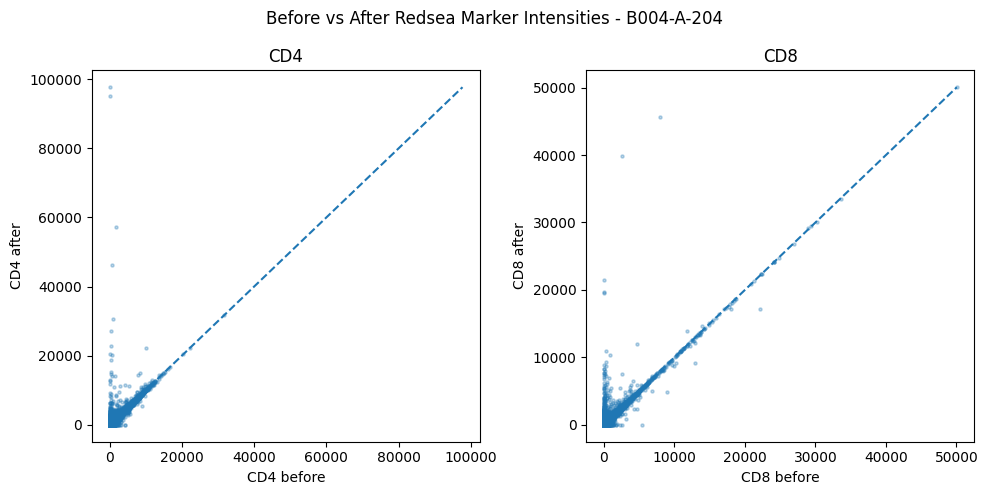

In [7]:
# Run it (will create CD4 / CD8 scatter plots per slide)
plot_before_after_scatter()

In [8]:
import matplotlib.pyplot as plt

def plot_cd4_cd8_scatter_per_slide(base_dir=BASE_DIR, results_df=results_df, max_points=5000):
    """
    For each slide, plot:
      - CD4_before vs CD8_before
      - CD4_after  vs CD8_after
    using the single_cell_before_redsea / single_cell_after_redsea files.
    """
    for slide in results_df["slide"]:
        slide_path = os.path.join(base_dir, slide)
        if not os.path.isdir(slide_path):
            continue

        before, after = load_slide(slide_path)

        # Require both markers in both files
        needed = {"CD4", "CD8"}
        if not needed.issubset(before.columns) or not needed.issubset(after.columns):
            print(f"Skipping {slide}: CD4/CD8 not in both before/after.")
            continue

        # Subsample if large
        def subsample(df):
            if len(df) > max_points:
                return df.sample(max_points, random_state=0)
            return df

        before_plot = subsample(before[["CD4", "CD8"]])
        after_plot  = subsample(after[["CD4", "CD8"]])

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle(f"CD4 vs CD8 Before/After Redsea - {slide}")

        # Before
        ax = axes[0]
        ax.scatter(before_plot["CD4"], before_plot["CD8"], alpha=0.3, s=5)
        ax.set_xlabel("CD4 before")
        ax.set_ylabel("CD8 before")
        ax.set_title("Before")

        # After
        ax = axes[1]
        ax.scatter(after_plot["CD4"], after_plot["CD8"], alpha=0.3, s=5)
        ax.set_xlabel("CD4 after")
        ax.set_ylabel("CD8 after")
        ax.set_title("After")

        plt.tight_layout()
        plt.show()


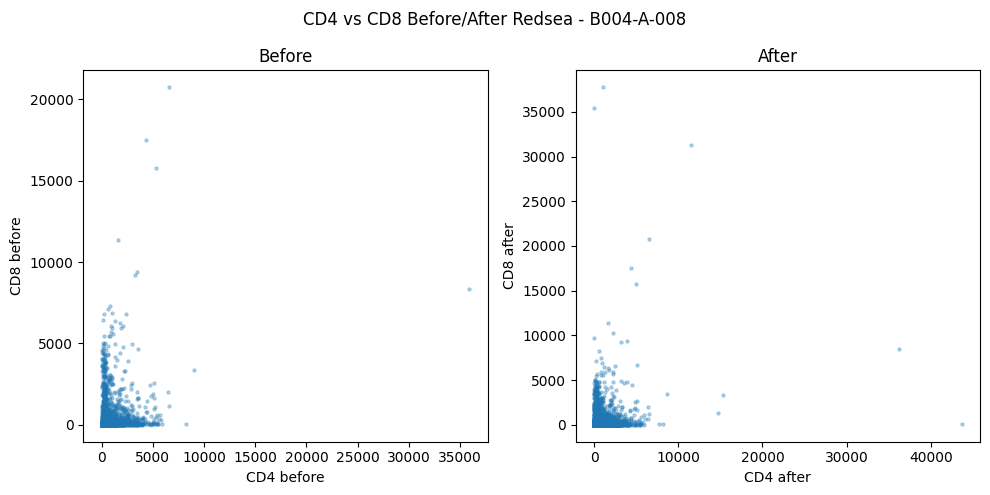

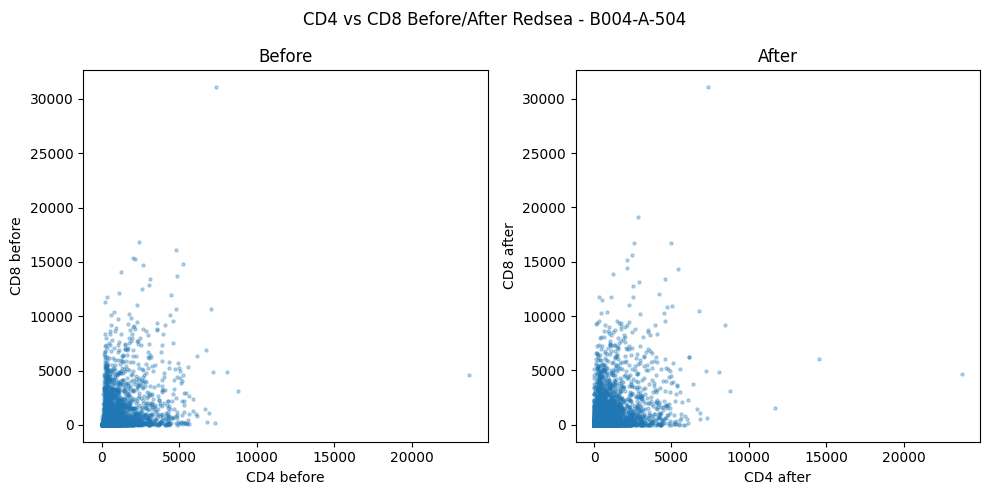

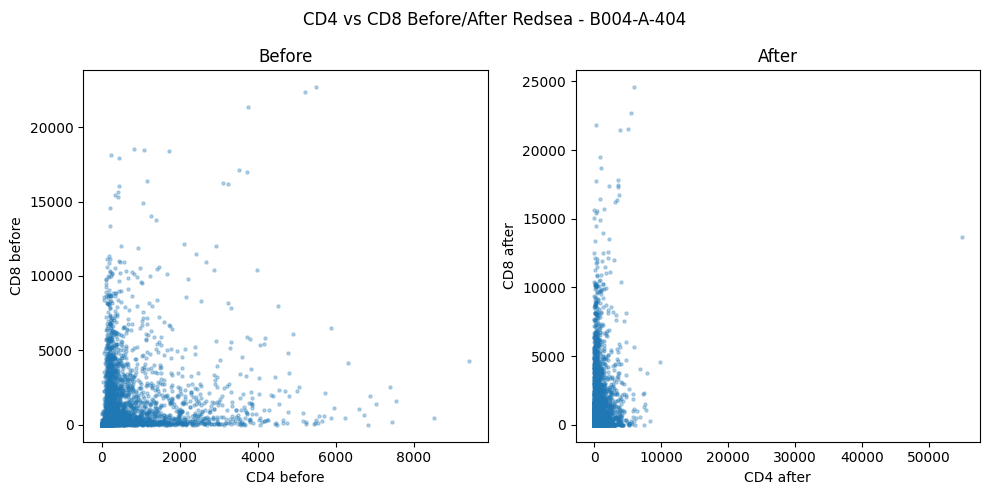

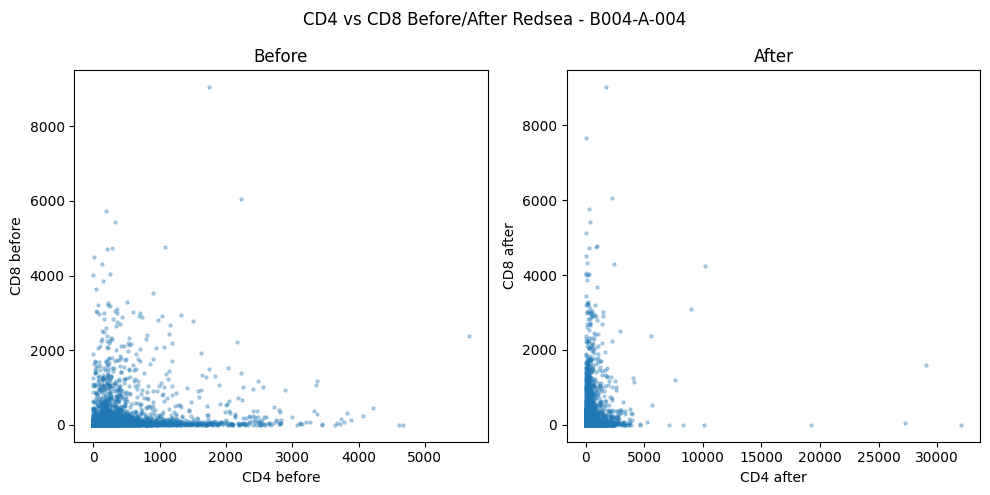

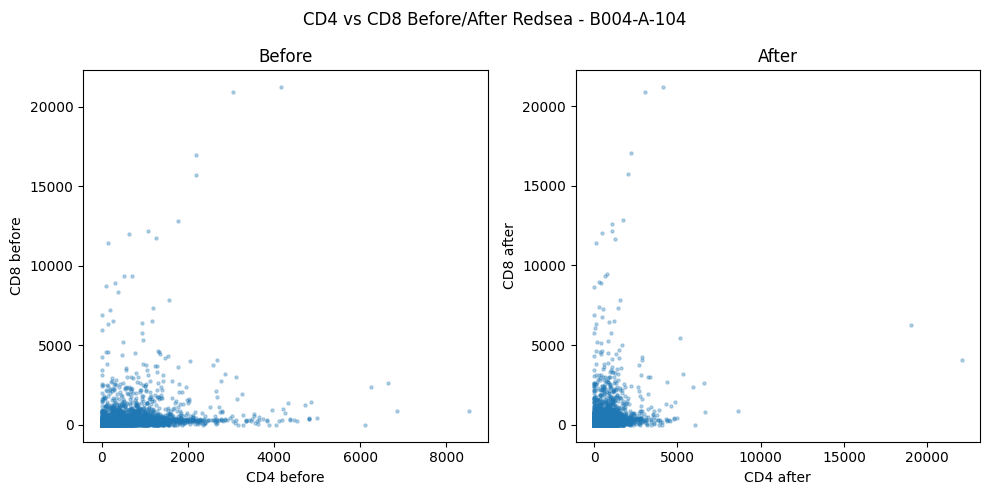

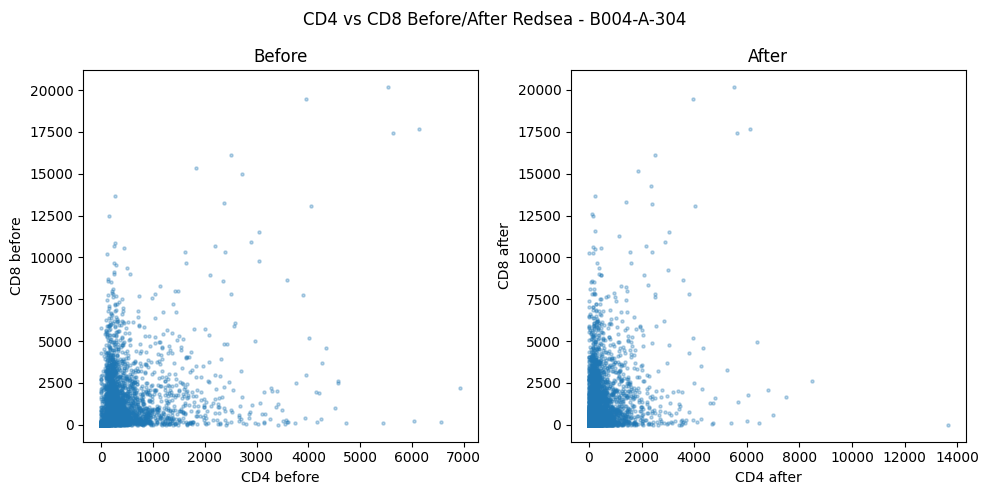

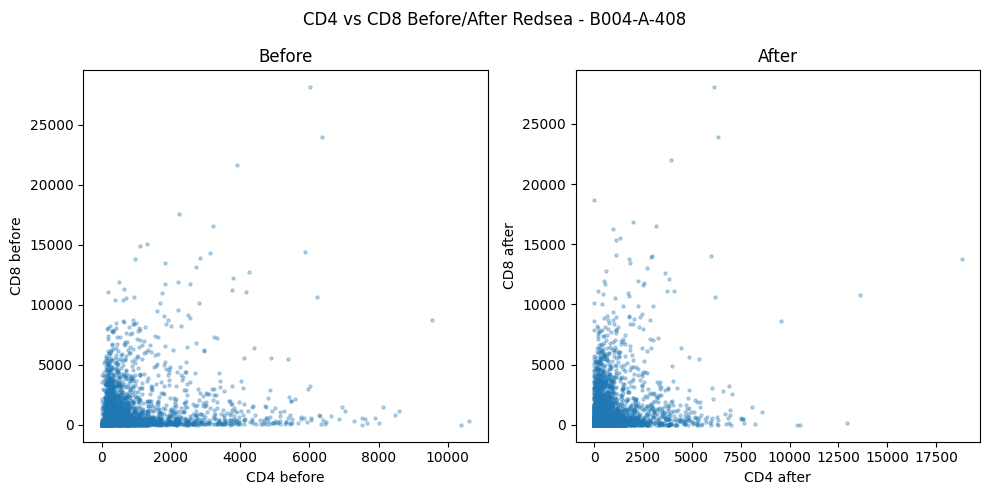

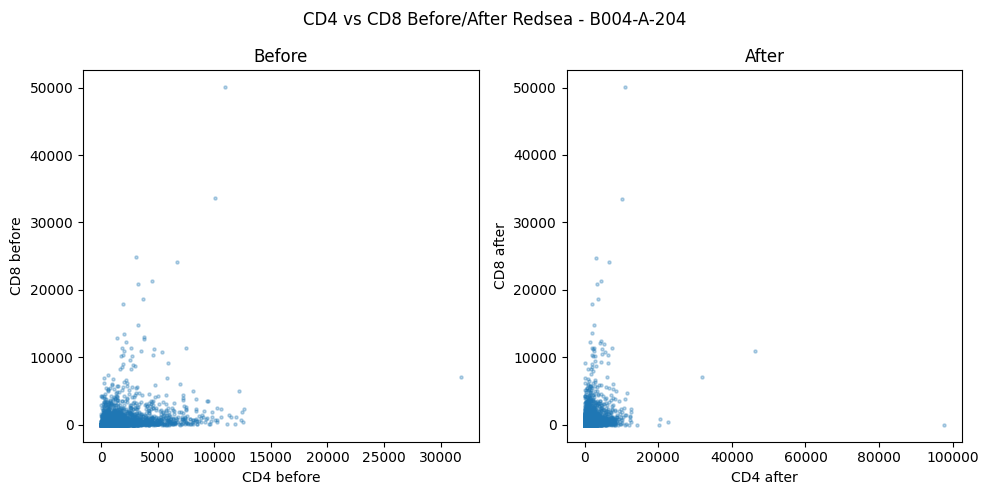

In [9]:

plot_cd4_cd8_scatter_per_slide()